In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets

import warnings
warnings.simplefilter("ignore")

try:
    import plotly.plotly as py
except:
    ! pip3 install --user plotly
    import plotly.plotly as py

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

try:
    import seaborn as sns
except:
    ! pip3 install --user seaborn
    import seaborn as sns

/Users/adityadev/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
df = pd.read_csv("Data/GlobalLandTemperaturesByCity.csv")

df['dt'] = pd.to_datetime(df['dt'])

df.index = df['dt']
del df['dt']

df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)
df["City"] = df["City"] + ", " + df["Country"]
df = df.drop("Country", 1)

df = df.dropna()

cities = set(df.City)

In [5]:
def check_stationarity(city_df):
    city_df.plot(figsize=(10, 10))
    
    city_df.hist(figsize=(10, 10))
    plt.show()
    
    X = city_df["AverageTemperature"].values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
    if (abs(mean1-mean2) <= 10 and abs(var1-var2) <= 10):
        print("Time Series may be Stationary, since means and variances vary only slightly.\n")
    else:
        print("Time Series may NOT be Stationary, since means and variances vary significantly.\n")
        
    print("Performing Augmented Dickey-Fuller Test to confirm stationarity...")
    
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    p = result[1]
    if (p > 0.05):
        print("Time Series is NOT Stationary, since p-value > 0.05")
        city_df = city_df.diff()  
        return False
    else:
        print("Time Series is Stationary, since p-value <= 0.05")
        return True

In [6]:

city_drop_down_menu = widgets.Dropdown(
    options=sorted(list(cities)),
    value='New York, United States',
    description='City:',
    disabled=False,
)

city_drop_down_menu

A Jupyter Widget

In [7]:
chosen_city = city_drop_down_menu.value
city_df = df[df.City == chosen_city].drop("City", 1)

Stationarity Check for New York, United States


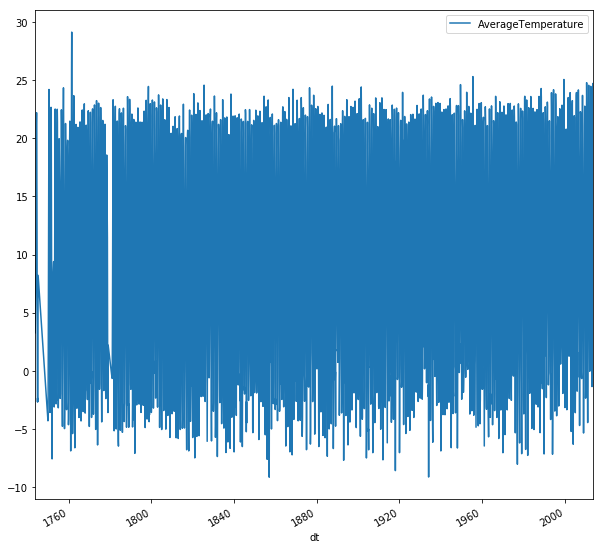

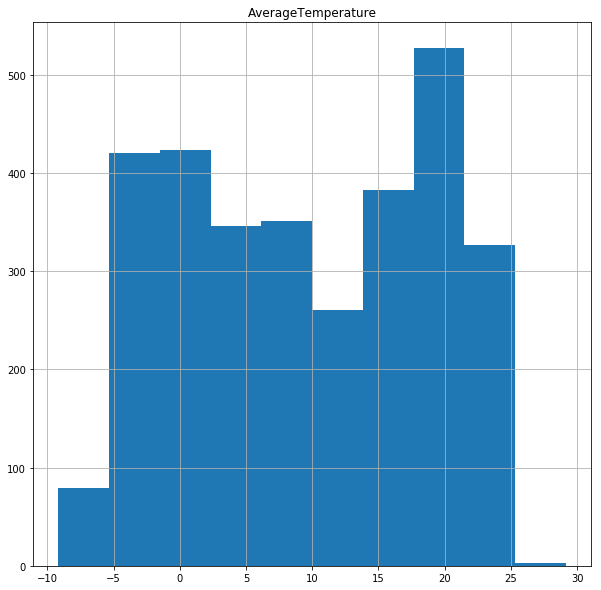

mean1=9.117772, mean2=9.928560
variance1=86.640935, variance2=84.126356
Time Series may be Stationary, since means and variances vary only slightly.

Performing Augmented Dickey-Fuller Test to confirm stationarity...
ADF Statistic: -5.157735
p-value: 0.000011
Time Series is Stationary, since p-value <= 0.05


In [8]:
print ("Stationarity Check for %s" % chosen_city)
is_stationary = check_stationarity(city_df)

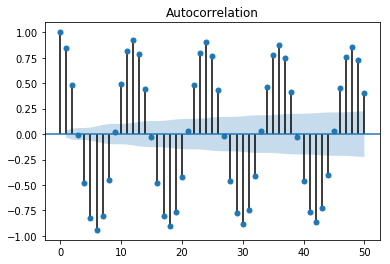

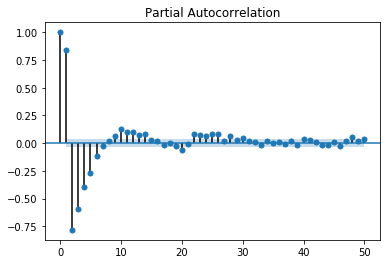

In [9]:

plot_acf(city_df,lags = 50)
plot_pacf(city_df,lags = 50)
plt.show()

if (is_stationary==True):
    d = 0
else:
    d = 1

In [10]:
p_range = q_range = list(range(0,3))  # taking values from 0 to 2

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(city_df, order=(p, d, q))
            results = model.fit(disp=-1)
            aic_values.append(ARMAResults.aic(results))
            bic_values.append(ARMAResults.bic(results))
            pq_values.append((p, q))
        except:
            pass

best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
print("(p,q) corresponding to lowest AIC score: ", best_pq)

(p,q) corresponding to lowest AIC score:  (2, 2)


In [12]:
from sklearn.metrics import mean_absolute_error

X = city_df.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(best_pq[0], 0, best_pq[1]))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
print()



predicted=9.808422, expected=11.223000
predicted=4.094831, expected=7.038000
predicted=0.830886, expected=-3.546000
predicted=-4.709755, expected=-4.673000
predicted=-3.698569, expected=-6.154000
predicted=-0.785993, expected=5.867000
predicted=10.507017, expected=7.519000
predicted=15.334964, expected=16.342000
predicted=20.917189, expected=19.556000
predicted=21.790844, expected=22.751000
predicted=20.690712, expected=22.333000
predicted=16.945357, expected=18.035000
predicted=10.835374, expected=11.195000
predicted=3.921050, expected=3.101000
predicted=-2.213279, expected=0.941000
predicted=-2.694386, expected=1.742000
predicted=0.915713, expected=-0.491000
predicted=3.114921, expected=0.417000
predicted=6.098374, expected=8.092000
predicted=12.798011, expected=16.047000
predicted=19.264910, expected=20.395000
predicted=21.656006, expected=22.587000
predicted=20.547620, expected=23.012000
predicted=17.371560, expected=16.250000
predicted=9.814440, expected=10.206000
predicted=3.1241

predicted=-0.059588, expected=1.197000
predicted=3.994195, expected=4.342000
predicted=8.891272, expected=9.141000
predicted=13.782318, expected=16.187000
predicted=18.744341, expected=20.587000
predicted=20.795417, expected=22.746000
predicted=19.821314, expected=21.301000
predicted=15.764520, expected=18.173000
predicted=10.619471, expected=12.341000
predicted=4.806053, expected=6.066000
predicted=0.027066, expected=1.899000
predicted=-1.779541, expected=-3.727000
predicted=-2.910358, expected=1.962000
predicted=3.469791, expected=3.586000
predicted=8.502968, expected=10.454000
predicted=14.834194, expected=13.661000
predicted=17.695045, expected=20.293000
predicted=20.569026, expected=22.163000
predicted=19.800662, expected=20.637000
predicted=15.770769, expected=17.153000
predicted=10.399896, expected=13.401000
predicted=5.837478, expected=4.743000
predicted=-0.210061, expected=-0.622000
predicted=-3.218739, expected=-3.442000
predicted=-2.702748, expected=-1.358000
predicted=2.019

predicted=21.136725, expected=19.351000
predicted=22.159450, expected=22.783000
predicted=21.122524, expected=22.381000
predicted=17.311357, expected=18.664000
predicted=11.473679, expected=12.277000
predicted=4.821381, expected=6.502000
predicted=0.009176, expected=-1.297000
predicted=-3.999793, expected=-5.494000
predicted=-4.508071, expected=-1.633000
predicted=1.331501, expected=2.072000
predicted=8.042951, expected=7.830000
predicted=14.470236, expected=13.540000
predicted=19.002575, expected=20.662000
predicted=22.417793, expected=22.019000
predicted=21.058485, expected=21.194000
predicted=16.863099, expected=19.228000
predicted=12.030016, expected=14.260000
predicted=6.495733, expected=4.702000
predicted=-0.590502, expected=1.794000
predicted=-2.437641, expected=-1.365000
predicted=-1.824175, expected=-3.369000
predicted=0.240131, expected=1.878000
predicted=6.622315, expected=7.159000
predicted=13.039696, expected=15.495000
predicted=19.556309, expected=18.195000
predicted=20.9

predicted=9.972584, expected=8.965000
predicted=2.562835, expected=5.917000
predicted=-0.384404, expected=1.093000
predicted=-1.691723, expected=-5.329000
predicted=-2.972340, expected=-1.720000
predicted=1.889334, expected=3.873000
predicted=9.180808, expected=8.562000
predicted=14.967982, expected=15.406000
predicted=19.796460, expected=19.940000
predicted=21.603332, expected=24.287000
predicted=21.590988, expected=23.505000
predicted=17.895739, expected=16.751000
predicted=10.188537, expected=8.606000
predicted=2.061742, expected=6.350000
predicted=-0.591885, expected=-1.032000
predicted=-3.204891, expected=-0.429000
predicted=-0.514461, expected=-1.547000
predicted=2.647485, expected=3.162000
predicted=8.480873, expected=8.201000
predicted=14.044706, expected=15.034000
predicted=19.033528, expected=20.717000
predicted=21.798594, expected=22.201000
predicted=20.474244, expected=21.305000
predicted=16.434033, expected=17.843000
predicted=10.893851, expected=11.708000
predicted=4.6890

predicted=2.294403, expected=1.125000
predicted=7.325219, expected=10.633000
predicted=15.465940, expected=13.267000
predicted=18.783917, expected=22.169000
predicted=22.751596, expected=23.704000
predicted=21.778529, expected=23.941000
predicted=18.231889, expected=20.238000
predicted=12.333979, expected=12.058000
predicted=4.447844, expected=7.019000
predicted=-0.347443, expected=-1.757000
predicted=-4.698130, expected=1.608000
predicted=-0.716272, expected=-0.565000
predicted=2.574231, expected=3.776000
predicted=8.309127, expected=10.709000
predicted=15.038374, expected=15.637000
predicted=19.220591, expected=20.445000
predicted=21.115015, expected=24.165000
predicted=20.957673, expected=22.420000
predicted=16.875493, expected=16.946000
predicted=10.070429, expected=10.811000
predicted=3.566486, expected=8.418000
predicted=1.152254, expected=3.861000
predicted=-0.081261, expected=0.412000
predicted=0.065615, expected=-4.713000
predicted=-0.330288, expected=2.947000
predicted=6.4833

In [14]:
from math import sqrt
mse = mean_squared_error(list(test), list(predictions))
print("Mean Squared Error:", mse)

mae = mean_absolute_error(list(test), list(predictions))
print("Mean Absolute Error:", mae)

rmse =sqrt(mean_absolute_error(list(test), list(predictions)))
print("root Mean square Error:",rmse)

Mean Squared Error: 4.255147049599221
Mean Absolute Error: 1.6461608766769245
root Mean square Error: 1.2830280108699592


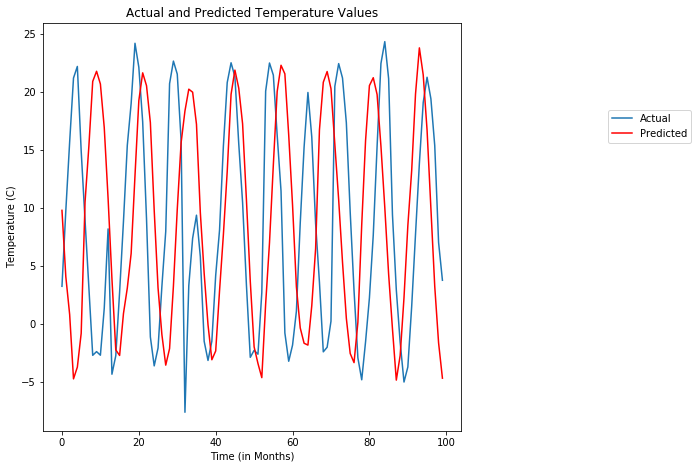

In [15]:
plt.figure(figsize=(7.5,7.5))
plt.plot(list(city_df.AverageTemperature)[:100], label="Actual")
plt.plot(list(predictions)[:100], 'r', label="Predicted")

plt.xlabel("Time (in Months)")
plt.ylabel("Temperature (C)")
plt.title("Actual and Predicted Temperature Values")

plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8))
plt.show()

In [26]:
years_drop_down_menu = widgets.Dropdown(
    options=list(range(1,201)),
    value=10,
    description='No. of Years:',
    disabled=False,
)

years_drop_down_menu

A Jupyter Widget

In [27]:
num_years = years_drop_down_menu.value
last_month_in_dataset = city_df.index[-1].month  
remaining_months = 12 - last_month_in_dataset  
number_of_steps = remaining_months + num_years * 12  

out_of_sample_forecast = model_fit.forecast(steps=number_of_steps)[0]  

out_of_sample_forecast = out_of_sample_forecast[remaining_months:]  

In [28]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
i = 0
for x in out_of_sample_forecast[-12:]:  # last year
    print(months[i]+": ", x, 'C')
    i += 1

January:  0.30317534448595795 C
February:  -0.07143569308767805 C
March:  2.1416235057006903 C
April:  6.319183738364128 C
May:  11.314616181302746 C
June:  15.772391188349417 C
July:  18.49577380520127 C
August:  18.76795230804897 C
September:  16.540469289507488 C
October:  12.43948821791033 C
November:  7.590059334344929 C
December:  3.3076304067727773 C


In [29]:
# plotting the predicted values for the nth year

trace = go.Scatter(
    x = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
    y = out_of_sample_forecast[-12:],
    mode = 'lines',
    name = 'Average Temperature'
)

layout = go.Layout(
    title='Predicted Temperatures for the Year %d' % (2013+num_years),
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Temperature (C)',
    )
)
data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [20]:
# plot monthly temperature changes from 2013 to 2013+n years
fig, ax = plt.subplots(nrows=4, ncols=3)

monthly_change = {}

for month in range(12):
    temp = month
    for year in range(num_years):
        if month not in monthly_change:
            monthly_change[month] = [out_of_sample_forecast[temp]]
        else:
            monthly_change[month].append(out_of_sample_forecast[temp])
        temp+=12

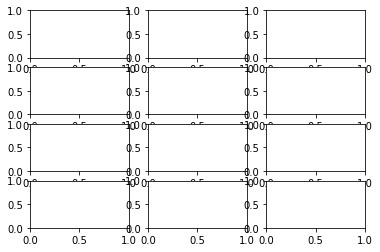

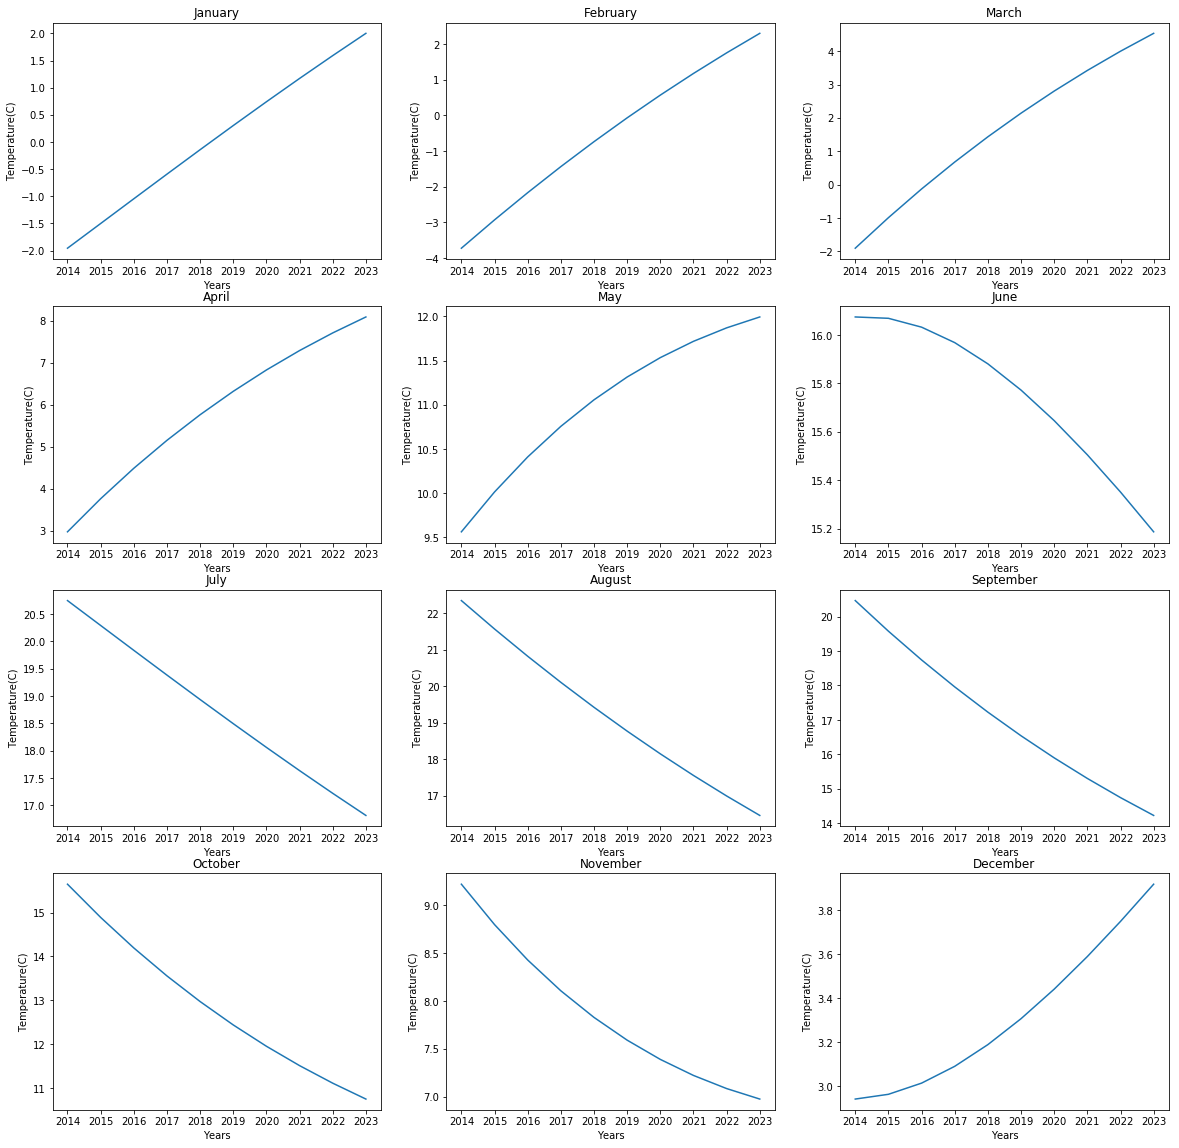

In [21]:
plt.figure(figsize=(20,20))
for pos in range(0,12):
    plt.subplot(4,3,pos+1)
    plt.plot(monthly_change[pos])
    plt.xticks(np.array(range(num_years)), [i for i in range(2014,2014+num_years)])
    plt.title(months[pos])
    plt.xlabel('Years')
    plt.ylabel('Temperature(C)')

plt.show()